## Importing Libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import joblib

## Data Cleaning & Preprocessing

In [32]:
# Loading dataset 
df = pd.read_csv('dataset.csv')  
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [33]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [34]:
# TotalCharges should be numeric, but it is object due to blanks
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Checking for missing values
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [35]:
# Droping rows with missing TotalCharges
df = df.dropna()

# Quick View of Churn Distribution
print(df['Churn'].value_counts())

Churn
No     5163
Yes    1869
Name: count, dtype: int64


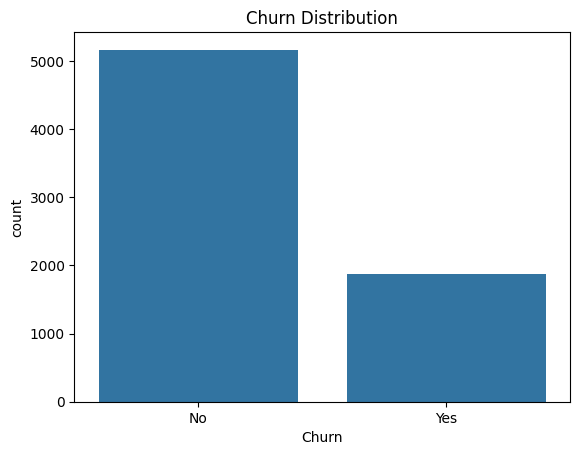

In [36]:
# Visualizing Churn Distribution
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

In [37]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Feature Engineering

In [38]:
# Encoding Binary Columns (Yes/No)
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = df[col].apply(lambda x: 1 if x == 'Yes' else 0)

In [39]:
# Selecting 7 features
features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
target = 'Churn' 

X = df[features]
y = df[target].apply(lambda x: 1 if x == 'Yes' else 0) 

In [40]:
# Spliting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Scaling Numerical Columns Only
scaler = StandardScaler()
X_train_scaled_num = scaler.fit_transform(X_train[['tenure', 'MonthlyCharges', 'TotalCharges']])
X_test_scaled_num = scaler.transform(X_test[['tenure', 'MonthlyCharges', 'TotalCharges']])

In [42]:
# Combine Scaled Numerical with Binary Features
X_train_final = np.concatenate((X_train_scaled_num, X_train[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']].values), axis=1)
X_test_final = np.concatenate((X_test_scaled_num, X_test[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']].values), axis=1)

## Model Training

In [43]:
# Training 5 Models
lr_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier()
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
cat_model = CatBoostClassifier(verbose=0)

# Fitting
lr_model.fit(X_train_final, y_train)
rf_model.fit(X_train_final, y_train)
xgb_model.fit(X_train_final, y_train)
cat_model.fit(X_train_final, y_train)

# Stacking Ensemble
stack_model = StackingClassifier(estimators=[
    ('lr', lr_model),
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('cat', cat_model)
], final_estimator=LogisticRegression())
stack_model.fit(X_train_final, y_train)

c:\Users\arsal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\arsal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\arsal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:50:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                               ('rf', RandomForestClassifier()),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=Non...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x000001BC948F6B70>)],
                   final_estimator=LogisticRegression())

## Evaluation

In [44]:
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'CatBoost': cat_model,
    'Stacking Ensemble': stack_model
}

for name, model in models.items():
    y_pred = model.predict(X_test_final)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



Logistic Regression Accuracy: 0.7903
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Confusion Matrix:
[[933 100]
 [195 179]]

Random Forest Accuracy: 0.7527
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1033
           1       0.54      0.45      0.49       374

    accuracy                           0.75      1407
   macro avg       0.68      0.66      0.66      1407
weighted avg       0.74      0.75      0.74      1407

Confusion Matrix:
[[891 142]
 [206 168]]

XGBoost Accuracy: 0.7676
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85 

## Visualization

### 1. Confusion Matrix Heatmap

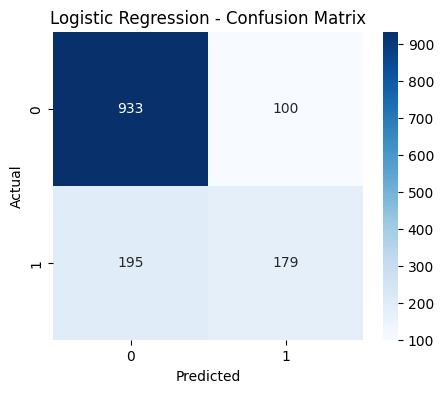

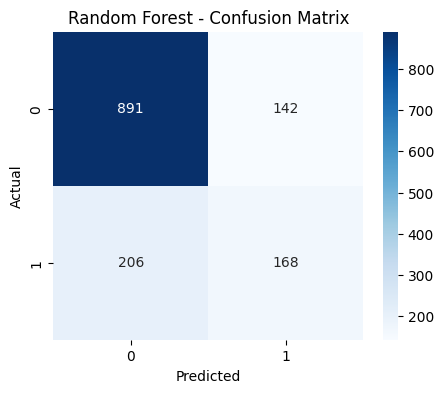

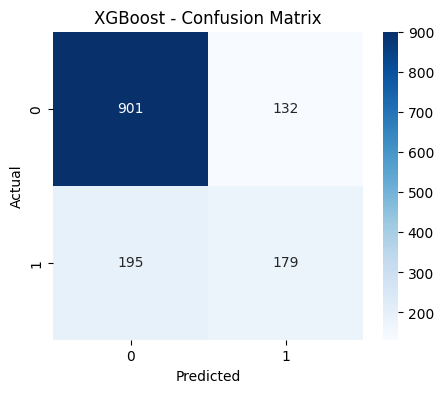

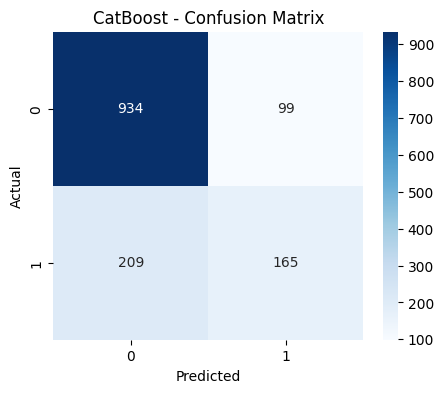

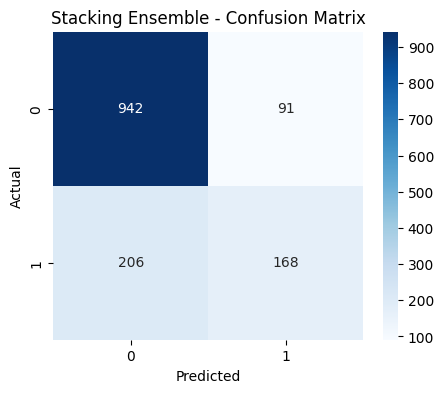

In [45]:
for name, model in models.items():
    y_pred = model.predict(X_test_final)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

### 2. Actual vs Predicted Bar Plot (For Visual Comparison)

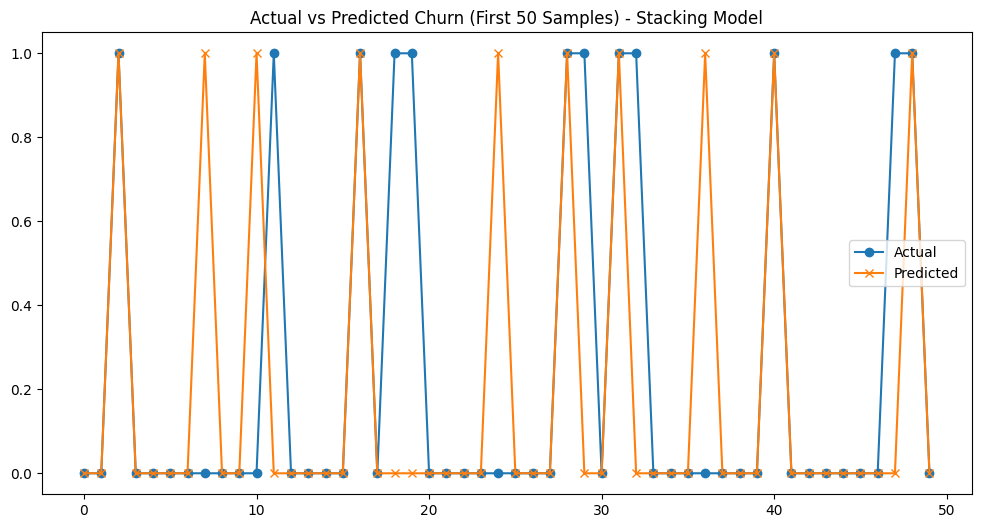

In [46]:
y_pred_stack = stack_model.predict(X_test_final)

comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_stack
}).reset_index(drop=True)

# Plotting Actual vs Predicted for first 50 samples
plt.figure(figsize=(12,6))
plt.plot(comparison_df['Actual'][:50], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'][:50], label='Predicted', marker='x')
plt.title('Actual vs Predicted Churn (First 50 Samples) - Stacking Model')
plt.legend()
plt.show()

### 3. Model Accuracy Comparison (Bar Plot)

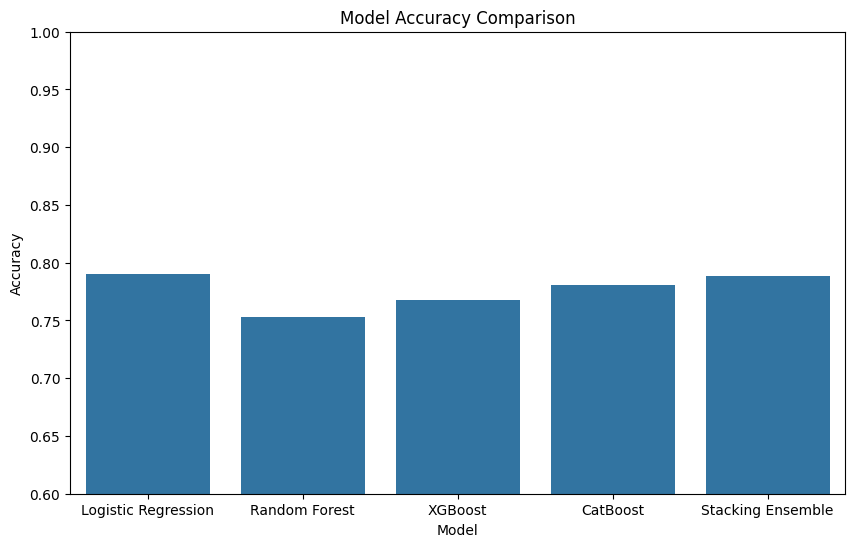

In [47]:
accuracies = []
for name, model in models.items():
    y_pred = model.predict(X_test_final)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append((name, acc))

# Plot
acc_df = pd.DataFrame(accuracies, columns=['Model', 'Accuracy'])

plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Accuracy', data=acc_df)
plt.ylim(0.6, 1)
plt.title('Model Accuracy Comparison')
plt.show()


## Saving Models

In [48]:
# Saving Models & Scaler
joblib.dump(lr_model, 'lr_model.pkl')
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(cat_model, 'cat_model.pkl')
joblib.dump(stack_model, 'stack_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']